# Training MLP to predict survival

In [361]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [428]:
import os
import plotly
from plotly import tools
import plotly.offline as py 
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from myutils import efron_estimator_tf, my_mse, plot_history, sub_plot_history

import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import InputLayer, Input
from keras.layers.core import Dense, Dropout, Flatten, Reshape, Activation
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2, l1
from keras.models import Model
from keras.callbacks import TensorBoard

from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split

## 1. Import and prepare the data:

In [368]:
data_df = pd.read_csv('simulated_data/survival_data_NS-3000_NC-3.csv')

# Concert to dictionary:
data = dict()
data['Xs'] = data_df[['x1','x2','x3']].as_matrix()
for col in ['h1','h2','t1','e1','t2','e2','bin_h1','bin_h2','bin_t1','bin_t2']:
    data[col] = data_df[[col]].as_matrix()

# train/test split indices:
train_idx, test_idx = train_test_split(
    range(data['Xs'].shape[0]), test_size=1000, random_state=777)

print('Data keys: ', data.keys())
print("Train split: %d; Test split: %d." % (len(train_idx), len(test_idx)))

Data keys:  dict_keys(['Xs', 'h1', 'h2', 't1', 'e1', 't2', 'e2', 'bin_h1', 'bin_h2', 'bin_t1', 'bin_t2'])
Train split: 2000; Test split: 1000.


## 2. Train MLPs

We age going to train different models ... The network is exactly the same for all the three models except for the last laler and the loss.

In [369]:
inputs = Input(shape=(3,))
x = Dense(5, activation='sigmoid')(inputs)
x = Dense(2, activation='sigmoid')(x)

### 2.1. Binary Cross-Entropy

In [370]:
preds = Dense(1, activation='sigmoid')(x)
crossentropy_model = Model(inputs=inputs, outputs=preds)

crossentropy_model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy')

In [376]:
history = crossentropy_model.fit(
                x   = data['Xs'][train_idx],
                y   = data['bin_t2'][train_idx],
                validation_split  = 0.35,
                batch_size        = 200,
                epochs            = 10,
                verbose           = 0)

train_preds = np.squeeze(crossentropy_model.predict(data['Xs'][train_idx]))

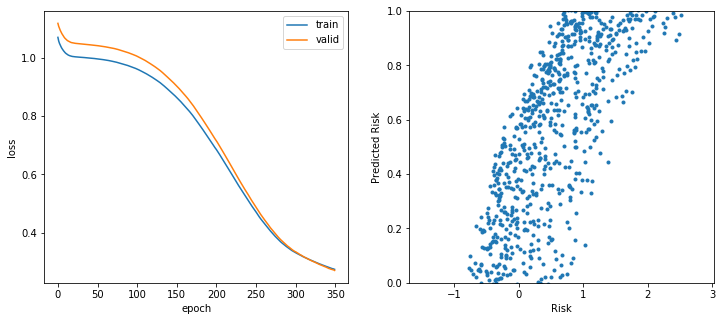

In [429]:
sub_plot_history(history, train_preds, data, train_idx, h_type=2, y_lim=(0,1))

### 2.2. Least-MSE-Regression

In [430]:
preds = Dense(1, activation='linear')(x)
mse_model = Model(inputs=inputs, outputs=preds)

mse_model.compile(optimizer = 'rmsprop', loss = 'mse')

In [431]:
history = mse_model.fit(
                x   = data['Xs'][train_idx],
                y   = data['h2'][train_idx],
                validation_split  = 0.35,
                batch_size        = 200,
                epochs            = 350,
                verbose           = 0 )

train_preds = np.squeeze(mse_model.predict(data['Xs'][train_idx]))

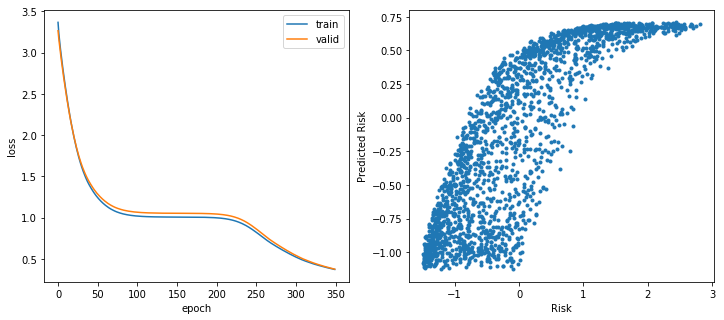

In [432]:
sub_plot_history(history, train_preds, data, train_idx, h_type=2)

In [291]:
1-concordance_index(data['t2'][test_idx], data['h2'][test_idx])

0.73425064568102139

In [442]:
1-concordance_index(data['t2'][train_idx], train_preds)

0.30789928488853779

### 2.3. Efron Survival Regression

In [435]:
preds = Dense(1, activation='linear')(x)
efron_model = Model(inputs=inputs, outputs=preds)

efron_model.compile(optimizer = 'adadelta', loss = efron_estimator_tf)

In [438]:
history = efron_model.fit(
                x   = data['Xs'][train_idx],
                y   = np.hstack((np.zeros_like(data['t1']),data['t2'],data['e2']))[train_idx],
                validation_split  = 0.35,
                batch_size        = 200,
                epochs            = 10,
                verbose           = 0)

train_preds = np.squeeze(efron_model.predict(data['Xs'][train_idx]))

Train on 1300 samples, validate on 700 samples
Epoch 1/10
1300/1300 [==============================] - 1s 408us/step - loss: 3.7341 - val_loss: 3.7103
Epoch 2/10
1300/1300 [==============================] - 1s 413us/step - loss: 3.7363 - val_loss: 3.7077
Epoch 3/10
1300/1300 [==============================] - 1s 413us/step - loss: 3.7382 - val_loss: 3.7051
Epoch 4/10
1300/1300 [==============================] - 1s 472us/step - loss: 3.7278 - val_loss: 3.7024
Epoch 5/10
1300/1300 [==============================] - 1s 475us/step - loss: 3.7323 - val_loss: 3.6998
Epoch 6/10
1300/1300 [==============================] - 1s 410us/step - loss: 3.7223 - val_loss: 3.6972
Epoch 7/10
1300/1300 [==============================] - 1s 433us/step - loss: 3.7244 - val_loss: 3.6945
Epoch 8/10
1300/1300 [==============================] - 1s 420us/step - loss: 3.7193 - val_loss: 3.6919
Epoch 9/10
1300/1300 [==============================] - 1s 420us/step - loss: 3.7181 - val_loss: 3.6893
Epoch 10/10
1300/

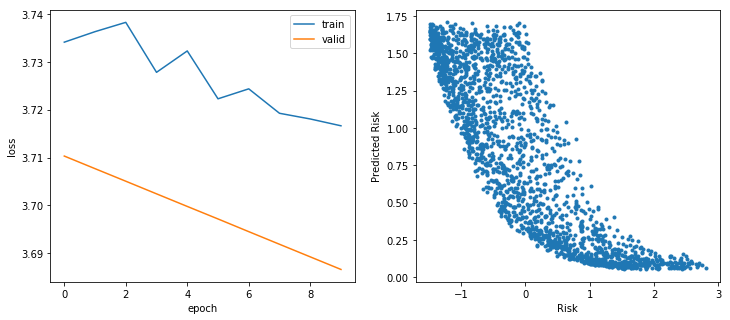

In [439]:
sub_plot_history(history, train_preds, data, train_idx, h_type=2)

In [200]:
1-concordance_index(data['t2'][test_idx], preds)

0.67487017819155382

## 3. Evaluate

array([[0],
       [0],
       [0],
       ..., 
       [0],
       [0],
       [0]])

In [28]:
model = Sequential()
model.add( InputLayer(input_shape=(3, ), name='InputLayer') )

model.add( Dense(2, kernel_regularizer=l1(.01)) )
model.add( Activation('sigmoid') )
model.add( Dense(3, kernel_regularizer=l1(.01)) )
model.add( Activation('sigmoid') )
model.add( Dense(1, activation='linear') )

model.compile(loss      = partial_likelihood,
              optimizer = 'adadelta')


In [29]:
opts                    = dict()
opts['dump_freq']       = 10
opts['plot_freq']       = 10
opts['krs_model']       = model
opts['loss']            = partial_likelihood
opts['metrics_l']       = None
opts['optimizer']       = 'adadelta'
opts['exp_path']        = '/Users/bychkov/GDD/projects/simu/models'
opts['exp_name']        = 'mlp_1'
opts['continue']        = False

In [30]:
network = Builder(  opts = opts,
                    train_data = ( train_x, train_y ),
                    test_data  = ( test_x, test_y ),
                    val_data   = ( val_x, val_y )  ) 

#history = network.train(epoches=15, batch=25, verbose=1)


initializing a new model...
Model initialized.


In [42]:
history = network.train(epoches=100, batch=train_x.shape[0], shuffle=True, verbose=0)

In [313]:
dfs   = list() 

# Train:
d  = OrderedDict()
d['id']    = train_y[:,3]
d['h_hat'] = np.squeeze( network.model.predict(train_x, batch_size=3000, verbose=1) )
dfs.append( pd.DataFrame( data=d ) )

# Validation:     
d  = OrderedDict()
d['id']    = val_y[:,3]
d['h_hat'] = np.squeeze( network.model.predict(val_x, batch_size=1000, verbose=1) )
dfs.append( pd.DataFrame( data=d ) )

# Test:     
d  = OrderedDict()
d['id']    = test_y[:,3]
d['h_hat'] = np.squeeze( network.model.predict(test_x, batch_size=1000, verbose=1) )
dfs.append( pd.DataFrame( data=d ) )
            
df = pd.concat(dfs, ignore_index=True, axis=0)
df.sort_values(by='id', inplace=True)
df.to_csv('models/mlp_1/preds.csv', index = False)

1000/1000 [==============================] - 0s
